### 项目目标：

* **有若干变色颗粒，受热会变色，温度和风力越大越容易变色**
* **使用提供的数据开发一个模型，该模型可以预测颗粒是否变色**
* **求要最短时间内使颗粒变色的最小特征和**
* **剔除无关的特征。**

### 项目介绍：

这是一个**受监督的二分类问题**，需要使用分类算法来预测颗粒是否变色。特征参数包括'预热风力','预热温度','干燥风力','干燥温度','冷却风力'。我们需要找到特征和最小的决策界面，即权重向量和偏置项



我们在**拿到一个机器学习问题之后，要做的第一件事就是制作出我们的机器学习项目清单**。下面给出了一个可供参考的机器学习项目清单，它应该适用于大多数机器学习项目，虽然确切的实现细节可能有所不同，但机器学习项目的一般结构保持相对稳定：

1. 数据清理和格式化

2. 探索性数据分析

3. 特征工程和特征选择

4. 基于性能指标比较几种机器学习模型

5. 对最佳模型执行超参数调整

6. 在测试集上评估最佳模型

7. 解释模型结果

8. 得出结论


提前设置机器学习管道结构让我们看到每一步是如何流入另一步的。但是，机器学习管道是一个迭代过程，因此我们并不总是以线性方式遵循这些步骤。我们可能会根据管道下游的结果重新审视上一步。例如，
* 虽然我们可以在构建任何模型之前执行特征选择，但我们可以使用建模结果返回并选择一组不同的特征。 
* 或者，建模可能会出现意想不到的结果，这意味着我们希望从另一个角度探索我们的数据。 
* 一般来说，你必须完成一步才能继续下一步，但不要觉得一旦你第一次完成一步，你就不能回头做出改进！你可以在任何时候返回前面的步骤并作出相应的修改

# Imports

使用标准的数据科学和机器学习库：`numpy，pandas`和`scikit-learn`。 使用`matplotlib`和`seaborn`进行可视化。
使用标准的数据科学和机器学习库：numpy，pandas和scikit-learn。 使用matplotlib和seaborn进行可视化。

In [1]:
#用于数据操作的 Pandas和numpy
import pandas as pd
import numpy as np

# 不显示关于在切片副本上设置值的警告
pd.options.mode.chained_assignment = None

# 一个 dataframe 最多显示60例
pd.set_option('display.max_columns', 60)

# 可视化工具包
import matplotlib.pyplot as plt
%matplotlib inline

#设置默认字体大小
plt.rcParams['font.size'] = 24

# 导入设置图片大小的工具
from IPython.core.pylabtools import figsize

#导入用于可视化的Seaborn
import seaborn as sns
sns.set(font_scale = 2)

# 把数据分为训练集和测试集

from sklearn.model_selection import train_test_split


In [2]:
# 输入缺失值和缩放值
from sklearn.preprocessing import  MinMaxScaler
from sklearn.impute import SimpleImputer as Imputer


# 机器学习模型
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# 超参数调整
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 1. 数据预处理

## 1.1 加载并检查数据

我们将把数据加载到pandas数据帧中，这是数据科学最有用的数据结构之一。将其视为Python中的电子表格，我们可以轻松地操作，清理和可视化。[Pandas有许多方法](http://pandas.pydata.org/pandas-docs/stable/)可以帮助使数据科学/机器学习管道尽可能顺利。

In [3]:
# 把数据读入pandas dataframe
data = pd.read_csv('data/ProcessData.csv')
print(type(data))
# 显示表头
data.head(12)

<class 'pandas.core.frame.DataFrame'>


,YuReFengLi,YuReWenDu,YuReShiJian,GanZaoFengLi,GanZaoWenDu,GanZaoShiJian,LengQueFengLi,LengQueShiJian,ChengPinLv
0,20,15,1,20,15,1,0,1,0
1,15,20,1,15,20,1,0,1,1
2,15,20,1,15,20,1,100,1,1
3,18,18,1,18,18,1,40,1,0
4,12,12,1,12,12,1,40,1,0
5,15,15,1,20,20,1,40,1,0
6,20,20,1,15,15,1,40,1,1
7,25,25,1,15,15,1,40,1,1
8,20,25,1,15,20,1,40,1,1
9,15,20,1,25,30,1,40,1,1


## 1.2 特征选择 
* 首先我们要确定能使颗粒变色最短时间
* 将**时间特征**以外的其他特征（以下称为**加热特征**）全部取上限，若颗粒无法变色则说明这个时间不是能使颗粒变色最短时间最短时间
* 将最短时间以外的其他数据剔除出去
* 将**加热特征**提取出来

In [4]:
Times = [1,1,1] # YuReShiJian,GanZaoShiJian,LengQueShiJian的取值
cols = ['YuReShiJian', 'GanZaoShiJian','LengQueShiJian'] # 时间特征
ncols = ['YuReFengLi','YuReWenDu','GanZaoFengLi','GanZaoWenDu','LengQueFengLi','ChengPinLv'] # 非时间特征
# data[cols].eq(value).all(axis=1)
data_need = data.loc[(data[cols[0]] == Times[0]) & (data[cols[1]] == Times[1])& (data[cols[2]] == Times[2]), ncols] # 满足条件的列
data_need.sort_values(by="ChengPinLv", ascending=False).head(12)

,YuReFengLi,YuReWenDu,GanZaoFengLi,GanZaoWenDu,LengQueFengLi,ChengPinLv
29,0,60,0,60,40,1
30,60,0,60,0,40,1
23,60,60,50,50,100,1
24,50,50,50,50,40,1
25,30,80,30,80,40,1
26,30,80,80,30,40,1
27,30,70,30,70,40,1
28,30,60,30,60,40,1
1,15,20,15,20,0,1
31,0,60,0,60,40,1


由上面可以得到最短时间为[1,1,1]颗粒即可变色，若不能，则不断调整时间直到找到颗粒可以变色为止的最短时间为止

## 1.3 分析数据

* 目的是找到异常，模式，趋势或关系。
* 若某一特征所有数值都一样，则这一特征的数据采集有问题。

In [5]:
# 查找所有数据都相同的列
same_cols = [col for col in data_need.columns if data_need[col].nunique() == 1]
# 输出结果
print("All columns with the same values: ", same_cols)

All columns with the same values:  []


## 1.4 划分数据集

In [6]:
# 将不同类别的数据分开
bad = data_need.loc[data_need['ChengPinLv']==0]
good = data_need.loc[data_need['ChengPinLv']==1]

In [7]:
# 将特征和目标分离开
features = data_need.drop(columns = 'ChengPinLv')
targets = pd.DataFrame(data_need['ChengPinLv'])

# 用 nan 替换 inf and -inf （required for later imputation）
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# 按照 7：3 的比例划分训练集和测试集

train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size = 0.3, random_state = 42)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(41, 5)
(18, 5)
(41, 1)
(18, 1)


## 1.5 寻找关系

为了查看**加热特征**对结果的影响，我们可以通过**加热特征**的值来绘制**密度图**。 密度图还显示单个加热特征的分布，可以认为是平滑的直方图。 

第一个图表显示了标签为变色的**加热特征**的数值分布.

D:\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


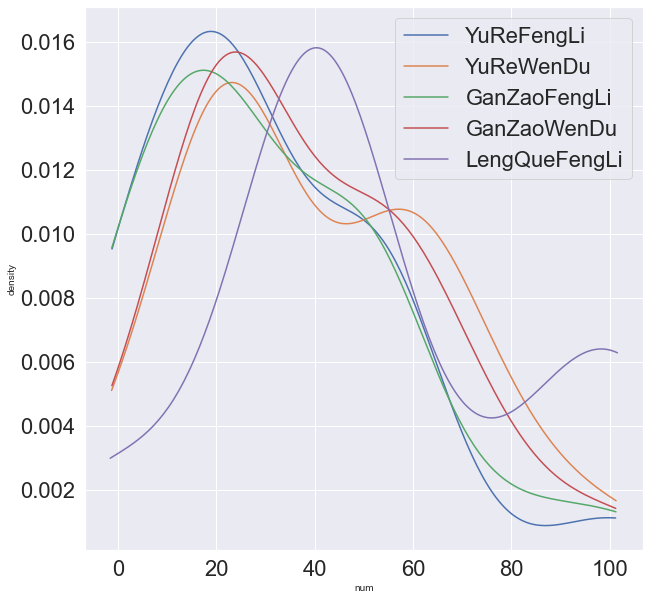

In [8]:
figsize(10,10)
types=['YuReFengLi','YuReWenDu','GanZaoFengLi','GanZaoWenDu','LengQueFengLi','ChengPinLv']
for b_type in types:
    subset = good[b_type]
    # sns.kdeplot函数绘制的是核密度估计曲线,核密度估计曲线是一种对概率密度函数的估计
    sns.kdeplot(subset.dropna(),label = b_type,shade = False,alpha = 1,cut=0.1)
    
plt.xlabel('num', size = 10) 
plt.ylabel('density', size = 10)
plt.legend()
plt.show()

第二个图表显示了标签为不变色的**加热特征**的数值分布.

D:\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


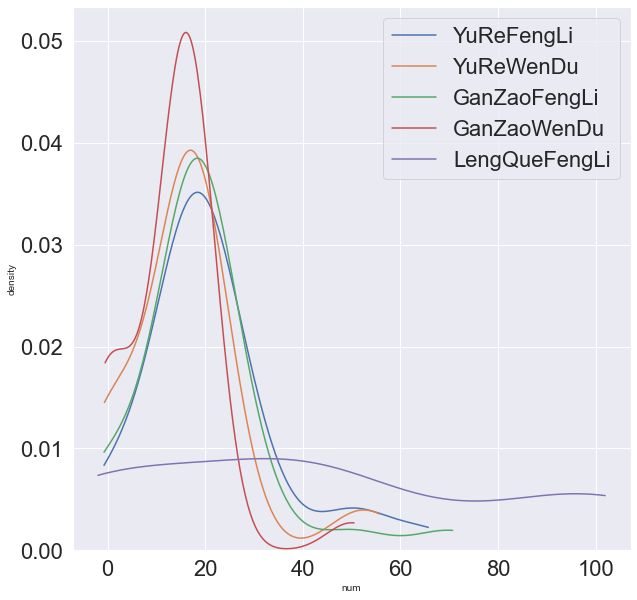

In [9]:
figsize(10,10)
types=['YuReFengLi','YuReWenDu','GanZaoFengLi','GanZaoWenDu','LengQueFengLi','ChengPinLv']
for b_type in types:
    subset = bad[b_type]
    sns.kdeplot(subset.dropna(),label = b_type,shade = False, alpha = 1,cut=0.1)
    
plt.xlabel('num', size = 10) 
plt.ylabel('density', size = 10)
plt.legend()
plt.show()

## 1.6 特征缩放

在我们构建模型之前要采取的最后一步是[特征缩放](https://en.wikipedia.org/wiki/Feature_scaling)。这是很有必要的，因为特征具有不同的单位，我们希望对特征进行标准化，以使单位不影响算法。
* [线性回归和随机森林不需要特征缩放](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data)
* 但其他方法（例如支持向量机和k-最近邻）确实需要它，因为它们考虑了观测之间的欧氏距离。因此，在比较多个算法时，最佳做法是特征缩放。

有两种[特征缩放](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)的方法：

* 对于每个值，减去特征的平均值并除以特征的标准偏差。这称为标准化，并且导致每个特征具有0的均值和1的标准偏差。
* 对于每个值，减去特征的最小值并除以最大值减去特征的最小值（范围）。这可以确保特征的所有值都在0到1之间，这称为缩放到范围或标准化。


* 当我们训练缩放对象时，我们只想使用训练集。
* 当我们转换特征时，我们将转换训练集和测试集。

In [10]:
# Create the scaler object with a range of 0-1 - 创建范围为0-1的缩放器对象
scaler = MinMaxScaler(feature_range=(0, 1))

# Train on the training features
scaler.fit(features)

# 转换训练数据和测试数据
X_train = scaler.transform(train_features)
X_test = scaler.transform(test_features)

In [11]:
# Convert y to one-dimensional array (vector)
y_train = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

# 2.构建模型

## 2.1选择模型 

要找到权重和最小的决策界面，可以使用线性支持向量机（Linear SVM）算法。该算法的目标是找到一个最优的超平面，使得该超平面能够最好地将训练数据集中的样本分成两类。其中，最优超平面被定义为距离两个最近的训练样本点的距离最大的超平面。该距离被称为“间隔”（Margin），最大化间隔的超平面被称为“最大间隔超平面”。

支持向量机算法的数学表达式如下：

$$\min_{w,b,\xi} \frac{1}{2} w^T w + C \sum_{i=1}^m \xi_i$$

$$\text{s.t. } y_i(w^T x_i + b) \geq 1 - \xi_i, \ \xi_i \geq 0, \ i=1,\ldots,m$$

其中，$w$ 是超平面的法向量，$b$ 是偏移量，$\xi_i$ 是松弛变量，$C$ 是惩罚参数，$y_i$ 是样本的类别标签，$x_i$ 是样本的特征向量。

这个表达式可以理解为最小化超平面法向量的范数，并在同时满足所有样本的约束条件的情况下最大化间隔。其中，约束条件保证了所有样本都被正确分类，而松弛变量则允许一些样本被错误分类或者位于超平面之间的区域内。惩罚参数 $C$ 控制了误分类样本的惩罚强度，即当 $C$ 较大时，算法会更加强调正确分类，而当 $C$ 较小时，算法会更加容忍错误分类。

要使用支持向量机算法进行分类，可以使用Python中的`sklearn.svm`模块。具体做法是首先创建一个`SVC`对象，然后使用`fit`方法拟合数据并进行分类。

`svm.SVC`是scikit-learn库中的一个支持向量机分类器。它具有许多可调参数，可以影响模型的性能和行为。以下是一些常用的参数及其含义：

- `C`：正则化参数。较小的C值将导致更强的正则化，可能导致模型欠拟合；较大的C值将导致较弱的正则化，可能导致模型过拟合。默认值为1.0。
- `kernel`：核函数。可以是'linear'，'poly'，'rbf'，'sigmoid'或自定义核函数。默认值为'rbf'。
- `degree`：多项式核函数的次数。仅在`kernel`为'poly'时使用。默认值为3。
- `gamma`：核系数。较大的gamma值将导致决策边界更适应于训练数据，可能导致模型过拟合。较小的gamma值将导致决策边界更平滑，可能导致模型欠拟合。默认值为'scale'，意味着1 / (n_features * X.var ())。
- `coef0`：核函数中的独立项。仅在`kernel`为'poly'或'sigmoid'时使用。默认值为0.0。
- `shrinking`：是否使用缩小启发式。如果启用，将使用启发式算法加速计算。默认值为True。
- `probability`：是否启用概率估计。如果启用，将启用概率预测。默认值为False。

In [12]:
def MySVC(model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    # 训练SVM模型
#     clf = SVC(kernel=kernel, C=C,gamma=gamma)
    svm_mae = fit_and_evaluate(model,X_train,X_test,y_train,y_test)
    # 获得权重向量
    n_support_vectors = model.n_support_[0] + model.n_support_[1]  # 支持向量的数量
    dual_coef = model.dual_coef_[0]  # dual_coef_属性包含了支持向量的权重
    support_vectors = model.support_vectors_  # 支持向量的坐标
    w = np.dot(dual_coef, support_vectors)  # 计算权重向量
    # w = clf.coef_[0]
    b= clf.intercept_[0]
    # 输出权重向量
    print('权重向量：', w)
    print('偏置向量：', b)
    print('[真阳性(TP)、真阴性(TN)、假阳性(FP)和假阴性(FN)],准确率,精确率,召回率,F1分数\n',svm_mae)
    return w,b,svm_mae

In [13]:
# 用于计算平均绝对误差的函数
def evaluate_binary_classification(y_true, y_pred):
    """
    计算二分类问题的混淆矩阵、准确率、精确率、召回率和F1分数。
    :param y_true: 真实标签。
    :param y_pred: 预测标签。
    :return: 混淆矩阵、准确率、精确率、召回率和F1分数。
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    return cm, accuracy, precision, recall, f1_score


# 接受模型，训练模型，并在测试集上评估模型
def fit_and_evaluate(model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    
    # 训练模型
    model.fit(X_train,y_train)
    
    # 做出预测和评估
    model_pred = model.predict(X_test)
    model_mae = evaluate_binary_classification(y_test,model_pred)
    
    # 返回性能指标
    return model_mae

## 2.2 建立Baseline

* 如果我们构建的模型不能胜过基线，那么我们可能不得不承认机器学习不适合这个问题。 这可能是
   * 因为我们没有使用正确的模型，
   * 因为我们需要更多的数据，
   * 或者因为有一个更简单的解决方案不需要机器学习。 
   
建立基线至关重要，因此我们最终可能不会构建机器学习模型，只是意识到我们无法真正解决问题。

In [14]:
# 训练SVM模型
clf = SVC(kernel='linear', C=1)
w,b,svm_mae = MySVC(clf)

权重向量： [ 0.46690764  1.71110992  0.59851772  1.86272    -0.04519896]
偏置向量： -1.3013423872514822
[真阳性(TP)、真阴性(TN)、假阳性(FP)和假阴性(FN)],准确率,精确率,召回率,F1分数
 (array([[10,  0],
       [ 4,  4]], dtype=int64), 0.7777777777777778, 1.0, 0.5, 0.6666666666666666)


将模型可视化，以便我们能更直观的查看模型的效果

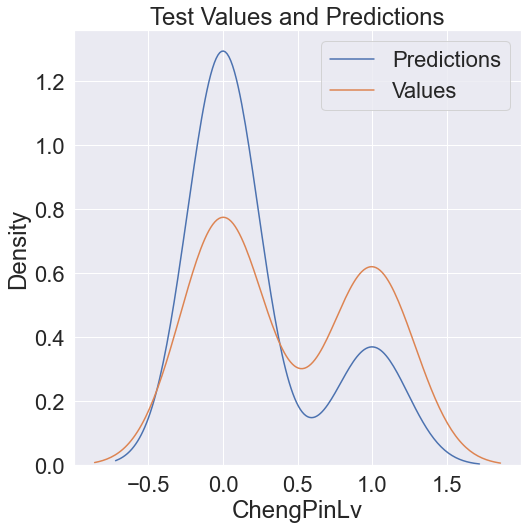

In [15]:
figsize(8, 8)

# Density plot of the final predictions and the test values
# 最终预测的密度图和测试值
sns.kdeplot(clf.predict(X_test), label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')
plt.legend(loc='upper right')
# Label the plot
plt.xlabel('ChengPinLv'); plt.ylabel('Density')
plt.title('Test Values and Predictions')
plt.show()

## 2.3 超参数优化

模型超参数定义[model hyperparameters are in contrast to model parameters](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) :

* **模型超参数**被认为最好通过机器学习算法来进行设置，在训练之前由数据科学家调整。 例如，随机森林中的树木数量，或者K-Nearest Neighbors Regression中使用的邻居数量。

* **模型参数**是模型在训练期间学习的内容，例如线性回归中的权重。

我们作为数据科学家通过**选择超参数**来控制模型，这些选择会对模型的最终性能产生显着影响（尽管通常不会像获取更多数据或工程特征那样有效）。调整模型超参数 [Tuning the model hyperparameters](http://scikit-learn.org/stable/modules/grid_search.html) 可以控制模型中欠拟合与过拟合的平衡。 

* 我们可以尝试通过制作**更复杂的模型**来校正欠拟合，例如在随机森林中使用更多树或在深度神经网络中使用更多层。 当我们的模型没有足够的容量（自由度）来学习特征和目标之间的关系时，模型会发生**欠拟合并且具有高偏差**。 
* 我们可以通过**限制模型的复杂度和应用正则化**来尝试纠正过度拟合。 这可能意味着降低多项式回归的次数，或将衰退层添加到深度神经网络。 **过拟合的模型具有高方差**并且实际上记住了训练集。 

**欠拟合和过拟合导致模型在测试集上的泛化性能变差**。

选择超参数的问题在于，没有放之四海而皆准的超参数。 因此，对于每个新数据集，我们必须找到最佳设置。 这可能是一个耗时的过程，但幸运的是，在Scikit-Learn中执行此过程有多种选择。

#### [常见设置超参数的做法有](https://www.jianshu.com/p/1b23afa34a47)：

1. **猜测和检查**：根据经验或直觉，选择参数，一直迭代。
2. **网格搜索**：让计算机尝试在一定范围内均匀分布的一组值。
3. **随机搜索**：让计算机随机挑选一组值。
4. **贝叶斯优化**：使用贝叶斯优化超参数，会遇到贝叶斯优化算法本身就需要很多的参数的困难。
5. **在良好初始猜测的前提下进行局部优化**：这就是 MITIE 的方法，它使用 BOBYQA 算法，并有一个精心选择的起始点。由于 BOBYQA 只寻找最近的局部最优解，所以这个方法是否成功很大程度上取决于是否有一个好的起点。在 MITIE 的情下,我们知道一个好的起点，但这不是一个普遍的解决方案，因为通常你不会知道好的起点在哪里。从好的方面来说，这种方法非常适合寻找局部最优解。稍后我会再讨论这一点。
6. 最新提出的 **LIPO 的全局优化方法**。这个方法没有参数，而且经验证比随机搜索方法好。

下面使用随机搜索和交叉验证进行超参数调整

**随机搜索**是指我们选择超参数来评估的方法：

* 我们定义一系列选项，然后随机选择要尝试的组合。 

通常，当我们对最佳模型超参数的知识有限时，随机搜索会更好。

**交叉验证**是用于评估超参数性能的方法：我们使用K-Fold交叉验证，而不是将训练设置拆分为单独的训练和验证集，以减少我们可以使用的训练数据量。

* 这意味着将训练数据划分为K个折叠，然后进行迭代过程，我们首先在K-1个折叠上进行训练，然后评估第K个折叠的性能。
   * 我们重复这个过程K次，所以最终我们将测试训练数据中的每个例子，关键是每次迭代我们都在测试我们之前没有训练过的数据。

* 在K-Fold交叉验证结束时，我们将每个K次迭代的平均误差作为最终性能度量，然后立即在所有训练数据上训练模型。

* 我们记录的性能用于比较超参数的不同组合。

在这里，我们将使用**交叉验证实现随机搜索**，以选择梯度增强回归量的最佳超参数。我们首先定义一个网格，然后执行以下迭代过程：

* 从网格中随机抽样一组超参数，使用4倍交叉验证评估超参数，
* 然后选择具有最佳性能的超参数。

当然，我们实际上并没有自己做这个迭代，我们让Scikit-Learn和`RandomizedSearchCV`为我们完成这个过程！

在下面的代码中，我们创建了随机搜索对象，传递以下参数：

* `estimator`: 模型
* `param_distributions`: 我们定义的参数的分布
* `cv` ：用于k-fold交叉验证的folds 数量
* `n_iter`: 不同的参数组合的数量
* `scoring`: 评估候选参数时使用的指标
* `n_jobs`: 核的数量（-1 时全部使用）
* `verbose`: 显示信息的数量
* `return_train_score`: 每一个cross-validation fold 返回的分数
* `random_state`: 修复使用的随机数生成器，因此每次运行都会得到相同的结果

随机搜索对象的训练方式与任何其他scikit-learn模型相同。训练之后，我们可以比较所有不同的超参数组合，找到效果最好的组合。

In [29]:
from scipy.stats import uniform
# define the hyperparameter space
gammalist_1 = np.linspace(0, 1, 10).round(1).tolist()
gammalist_2 = np.linspace(1, 100, 100).round(1).tolist()
gammalist = gammalist_1 + gammalist_2
gammalist.append('scale')
param_dist = {'C': uniform(loc=0, scale=1000), 'kernel': ['linear','rbf','sigmoid'], 'gamma': gammalist}
# Set up the random search with 4-fold cross validation
random_search  = RandomizedSearchCV(estimator=clf,param_distributions=param_dist, n_iter=1000,cv=4)

In [30]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=SVC(C=370.12115648641065, gamma=0.1),
                   n_iter=3000,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CFE3E8BDF0>,
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.0, 2.0,
                                                  3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                                                  9.0, 10.0, 11.0, 12.0, 13.0,
                                                  14.0, 15.0, 16.0, 17.0, 18.0,
                                                  19.0, 20.0, ...],
                                        'kernel': ['linear', 'rbf', 'sigmoid']})

In [31]:
print(random_search.best_params_)

{'C': 144.84661947741617, 'gamma': 0.1, 'kernel': 'rbf'}


In [32]:
# 获取所有cv结果并按测试性能排序
random_results = pd.DataFrame(random_search.cv_results_).sort_values('mean_test_score', ascending = False)
random_results.sort_values(by="rank_test_score", ascending=True).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
1593,0.000000,0.000000,0.000000,0.000000,263.415602,0.1,rbf,"{'C': 263.41560243114156, 'gamma': 0.1, 'kerne...",0.818182,0.8,0.8,0.8,0.804545,0.007873,1
2307,0.000000,0.000000,0.000000,0.000000,255.482137,0.1,rbf,"{'C': 255.48213736188063, 'gamma': 0.1, 'kerne...",0.818182,0.8,0.8,0.8,0.804545,0.007873,1
934,0.003906,0.006766,0.000000,0.000000,256.037336,0.1,rbf,"{'C': 256.0373364927589, 'gamma': 0.1, 'kernel...",0.818182,0.8,0.8,0.8,0.804545,0.007873,1
890,0.000000,0.000000,0.000000,0.000000,144.846619,0.1,rbf,"{'C': 144.84661947741617, 'gamma': 0.1, 'kerne...",0.818182,0.8,0.8,0.8,0.804545,0.007873,1
2687,0.000000,0.000000,0.000000,0.000000,201.166971,0.1,rbf,"{'C': 201.16697115071625, 'gamma': 0.1, 'kerne...",0.818182,0.8,0.8,0.8,0.804545,0.007873,1
2060,0.000000,0.000000,0.000000,0.000000,294.790346,0.1,rbf,"{'C': 294.79034634427603, 'gamma': 0.1, 'kerne...",0.818182,0.8,0.8,0.8,0.804545,0.007873,1
545,0.001000,0.000009,0.000250,0.000433,57.209128,0.3,rbf,"{'C': 57.20912849399795, 'gamma': 0.3, 'kernel...",0.727273,0.8,0.8,0.8,0.781818,0.031492,7
453,0.000750,0.000433,0.000183,0.000318,104.753386,0.3,rbf,"{'C': 104.75338602982454, 'gamma': 0.3, 'kerne...",0.727273,0.8,0.8,0.8,0.781818,0.031492,7
717,0.000500,0.000500,0.000000,0.000000,18.093153,0.4,rbf,"{'C': 18.09315292720659, 'gamma': 0.4, 'kernel...",0.727273,0.8,0.8,0.8,0.781818,0.031492,7
2889,0.000000,0.000000,0.000000,0.000000,64.947922,0.3,rbf,"{'C': 64.94792237765179, 'gamma': 0.3, 'kernel...",0.727273,0.8,0.8,0.8,0.781818,0.031492,7


In [33]:
# for i in range(10):
clf = SVC(kernel=random_search.best_params_['kernel'], C=random_search.best_params_['C'],gamma=random_search.best_params_['gamma'])
w,b,svm_mae = MySVC(clf)
clf_full_pred = clf.predict(X_test)
# print(y_test)
# print(clf_full_pred)

权重向量： [ 3.38381251 23.39135409 -4.18583528 26.65061934 -4.99289632]
偏置向量： -3.341626114885575
[真阳性(TP)、真阴性(TN)、假阳性(FP)和假阴性(FN)],准确率,精确率,召回率,F1分数
 (array([[10,  0],
       [ 2,  6]], dtype=int64), 0.8888888888888888, 1.0, 0.75, 0.8571428571428571)


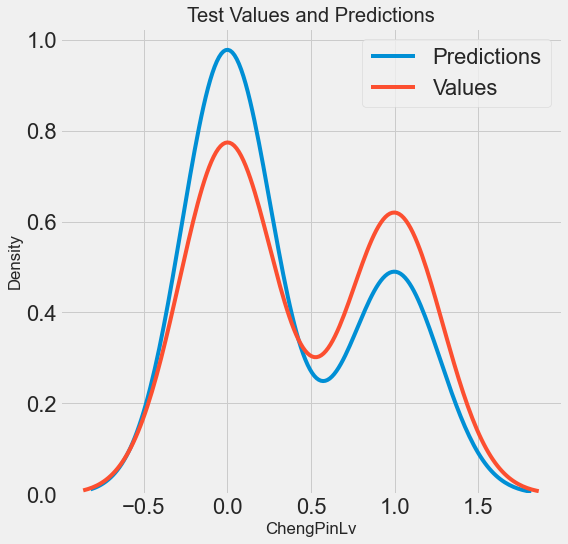

In [34]:
figsize(8, 8)

# Density plot of the final predictions and the test values
# 最终预测的密度图和测试值
sns.kdeplot(clf.predict(X_test), label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')
plt.legend(loc='upper right')
# Label the plot
plt.xlabel('ChengPinLv'); plt.ylabel('Density')
plt.title('Test Values and Predictions')
plt.show()

# 3.重要特征提取

## 3.1特征重要性 - Feature Importances
我们可以解释机器学习的基本方法之一是通过所谓的特征重要性。 这些可以解释为最能预测目标的变量。 虽然特征重要性的实际细节非常复杂. ([here is a Stack Overflow question on the subject](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined),但是我们可以使用相对值来比较特征并确定哪些与我们的问题最相关。 

在scikit-learn中，从训练好的模型中提取特征重要性非常容易。 我们将特征重要性存储在数据框中以分析和可视化它们。

In [22]:
# 将特征重要性提取到数据结构中
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': w})


feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

print(feature_results)

         feature  importance
0    GanZaoWenDu   32.520819
1      YuReWenDu   21.105694
2     YuReFengLi   14.320178
3   GanZaoFengLi   -1.108932
4  LengQueFengLi   -9.066040


Text(0.5, 1.0, 'Feature Importances from Random Forest')

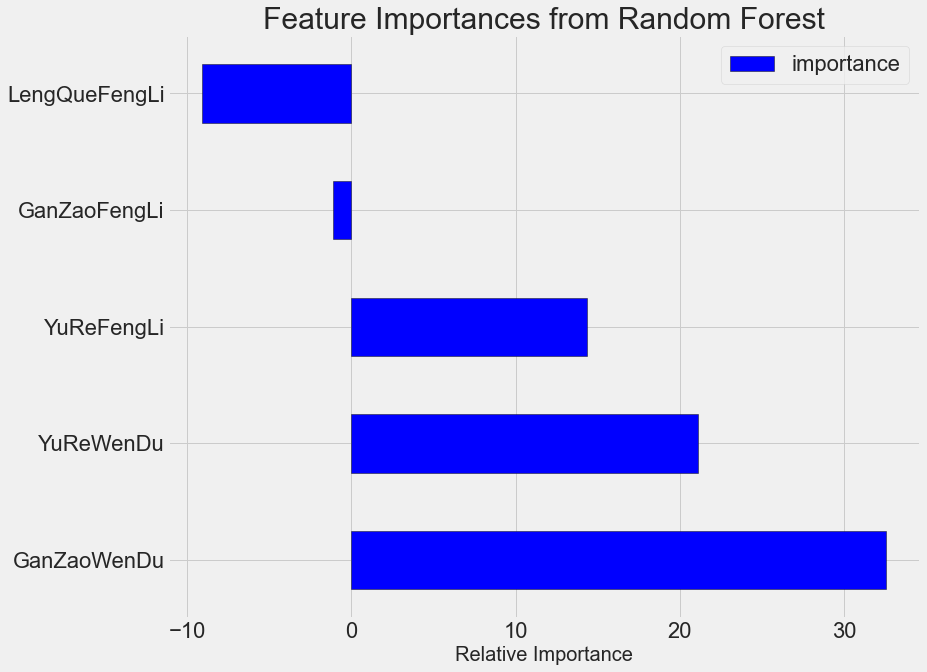

In [23]:
from IPython.core.pylabtools import figsize

figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue')
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30)

## 3.2 使用特征重要性进行特征选择

让我们尝试在模型训练中仅使用10个最重要的特征来查看性能是否得到改善。 我们还可以限制这些特征并重新评估模型。

In [24]:
# 提取最重要特征的名称
# important_features = feature_results['importance'].astype(float).gt(0)
important_features = abs(feature_results['importance'].astype(float))>=1
most_important_features = feature_results['feature'][important_features]
# 找到与每个特征名称对应的索引
important_indices = [list(train_features.columns).index(x) for x in most_important_features]
indices = sorted(important_indices)

# 数据集中只保留最重要的特征
X_reduced = X_train[:,indices]
X_test_reduced = X_test[:,indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (41, 5)
Most important testing  features shape:  (18, 5)


In [25]:
clf = SVC(kernel=random_search.best_params_['kernel'], C=random_search.best_params_['C'],gamma=random_search.best_params_['gamma'])
w,b,svm_my = MySVC(clf,X_reduced,X_test_reduced)
clf_reduced_pred = clf.predict(X_test_reduced)
print(y_test)
print(clf_full_pred)

权重向量： [14.32017838 21.10569419 -1.10893154 32.52081948 -9.06603974]
偏置向量： 1.203914186313299
[真阳性(TP)、真阴性(TN)、假阳性(FP)和假阴性(FN)],准确率,精确率,召回率,F1分数
 (array([[10,  0],
       [ 2,  6]], dtype=int64), 0.8888888888888888, 1.0, 0.75, 0.8571428571428571)
[0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0]
[0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0]


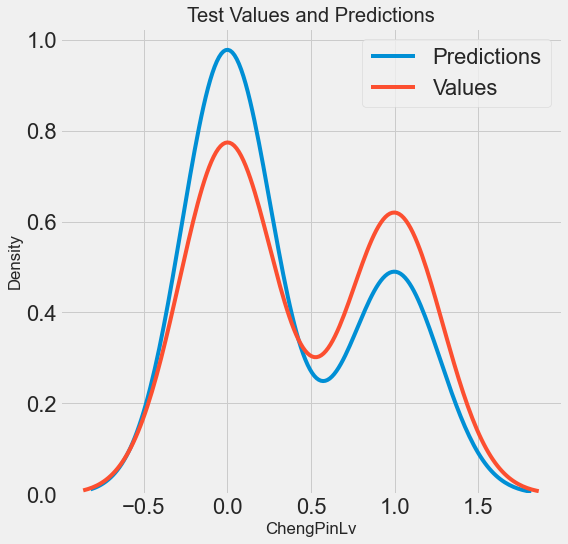

In [26]:
figsize(8, 8)

# Density plot of the final predictions and the test values
# 最终预测的密度图和测试值
sns.kdeplot(clf_reduced_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')
plt.legend(loc='upper right')

# Label the plot
plt.xlabel('ChengPinLv'); plt.ylabel('Density')
plt.title('Test Values and Predictions')
plt.show()

可以看出，减少特征并没有改善线性回归的结果！ 事实证明，低重要性特征中的额外信息确实可以提高性能。
随着特征数量的减少，模型结果稍差，我们将保留最终模型的所有特征。 减少特征数量的初衷是因为我们总是希望构建最简约的模型：

* 即具有足够特征的最简单模型
* 使用较少特征的模型将更快地训练并且通常更容易解释。

在现在这种情况下，保留所有特征并不是主要问题，因为训练时间并不重要，我们仍然可以使用许多特征进行解释。

In [27]:
if svm_mae[-1] > svm_my[-1]:
    clf = SVC(kernel=random_search.best_params_['kernel'], C=random_search.best_params_['C'],gamma=random_search.best_params_['gamma'])
    w,b,svm_mae = MySVC(clf)
# else:
#     scaler.fit(features[list(most_important_features.values)])

# 4.求要最短时间内使颗粒变色的最小特征和

我们可以使用scipy.optimize库中的minimize函数来解决优化问题。这个函数使用约束条件和边界来限制搜索空间，并返回使目标函数最小化的变量值

In [28]:
from scipy.optimize import minimize

# 定义最小化的目标函数
def objective(x):
    return sum(x)

# 定义预测值为正的约束条件
def constraint(x):
    return clf.decision_function([x])[0]

# 定义每个特性参数的边界
bounds = [(0, None) for i in range(len(train_features.columns))]

# 设置特征参数的初始猜测
x0 = [1 for i in range(len(train_features.columns))]

# 解决优化问题
result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})
# 打印在约束条件下使和最小的特征参数
print(pd.DataFrame(np.round(scaler.inverse_transform(pd.DataFrame([result.x]))).astype(int),columns=['YuReFengLi','YuReWenDu','GanZaoFengLi','GanZaoWenDu','LengQueFengLi']))

   YuReFengLi  YuReWenDu  GanZaoFengLi  GanZaoWenDu  LengQueFengLi
0           0          6             0           48              0
